In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

In [2]:
device = torch.device("cpu")

In [3]:
learning_rate = 0.001
batch_size = 16
num_epochs = 20
apply_dropout = False
dropout_p = 0.20
apply_bn = True
early_stopping_criteria= 5

val_proportion = 0.2



saved_model_fn = os.path.join('./', "model.pt")

In [4]:
data = fetch_california_housing()
X, y = data.data, data.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

### Set up Dataset and DataLoader

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

val_size = int(val_proportion*len(train_dataset))
train_size = len(train_dataset) - val_size
test_size = len(test_dataset)

print(f"number samples in train: {train_size}")
print(f"number samples in val: {val_size}")
print(f"number samples in test: {test_size}")

train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_dataset, 
                                                           lengths=[train_size, val_size],
                                                           generator=torch.Generator().manual_seed(20210315))

number samples in train: 13210
number samples in val: 3302
number samples in test: 4128


In [6]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Model Initialization, Loss, Optimizer

In [7]:
clf = nn.Sequential(
    nn.Linear(8, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

print(clf)

# instantiate the loss and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(clf.parameters(), lr=learning_rate)

Sequential(
  (0): Linear(in_features=8, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=1, bias=True)
)


### Initialize a dictionary to record training progress

In [8]:
train_state = {
    "train_loss": [],
    "train_score": [],
    "val_loss": [],
    "val_score": []
}

### Train the model
[Model saving and loading](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [9]:
best_val_loss = float('inf')
early_stopping_step = 0

for epoch in range(1, num_epochs+1):
    running_train_loss = 0.0 # running loss for every 200 steps during training
    train_loss = 0.0 # accumulated training loss for the entire epoch
    num_train_samples = 0 
    clf.train() # switch to training mode
    for batch_idx, (data, targets) in enumerate(train_loader): 
        targets = targets.view(-1, 1)       
        batch_size = data.shape[0]
        
        # forward pass
        preds = clf(data)
        loss = criterion(preds, targets)
        
        # back prop
        optimizer.zero_grad()
        loss.backward()
        
        # update model params
        optimizer.step()
        
        # evaluate performance for each batch
        running_train_loss += loss.item()
        train_loss += loss.item() * batch_size
        num_train_samples += batch_size

        # print training stat every 200 steps
        if ((batch_idx+1) % 200==0):
            print(f"[epoch {epoch} step {batch_idx}] running training loss: {running_train_loss/200:.3f}")
            running_train_loss = 0.0
    
    epoch_train_loss = train_loss/num_train_samples
    epoch_train_score = torch.mean(torch.abs(preds - targets)).item()
            
    # evaluate on the validation set every epoch
    clf.eval() # switch to evaluation mode
    val_loss = 0.0
    num_val_samples = 0 
    for data, targets in val_loader:
        targets = targets.view(-1, 1)
        data, targets = data.to(device), targets.to(device)
        batch_size = data.shape[0]
        data = data.reshape(batch_size, -1)
        preds = clf(data)
        loss = criterion(preds, targets)
        val_loss += loss.item() * data.shape[0]
        num_val_samples += batch_size
        # calculate accuracy
        preds = clf(data)

    epoch_val_loss = val_loss/num_val_samples
    epoch_val_score = torch.mean(torch.abs(preds - targets)).item()
    print(f"[epoch {epoch}] val loss: {epoch_val_loss:.3f}")
    
    # update train_state dict
    train_state['train_loss'].append(epoch_train_loss)
    train_state['train_score'].append(epoch_train_score)
    train_state['val_loss'].append(epoch_val_loss)
    train_state['val_score'].append(epoch_val_score)
    
    # early stopping
    # if (epoch_val_loss < best_val_loss):
    #     best_val_loss = epoch_val_loss
    #     early_stopping_step = 0
    #     print(f"current best validation loss: {best_val_loss:.3f}")
    #     torch.save(clf.state_dict(), saved_model_fn)
    #     print("=====>save the best model")
    # else:
    #     early_stopping_step += 1
    #     print(f"validation loss stops decreasing for {early_stopping_step} epoch")
    #     if (early_stopping_step==early_stopping_criteria):
    #         print("early stopping criteria reached")
    #         break
    # print("--------------------------------------------")
            
            

[epoch 1 step 199] running training loss: 3.277
[epoch 1 step 399] running training loss: 1.614
[epoch 1 step 599] running training loss: 2.113
[epoch 1 step 799] running training loss: 1.390
[epoch 1] val loss: 1.222
current best validation loss: 1.222
=====>save the best model
--------------------------------------------
[epoch 2 step 199] running training loss: 1.402
[epoch 2 step 399] running training loss: 3.173
[epoch 2 step 599] running training loss: 2.108
[epoch 2 step 799] running training loss: 1.366
[epoch 2] val loss: 1.054
current best validation loss: 1.054
=====>save the best model
--------------------------------------------
[epoch 3 step 199] running training loss: 1.177
[epoch 3 step 399] running training loss: 2.832
[epoch 3 step 599] running training loss: 2.063
[epoch 3 step 799] running training loss: 1.213
[epoch 3] val loss: 1.310
validation loss stops decreasing for 1 epoch
--------------------------------------------
[epoch 4 step 199] running training loss: 

### Test the network on the test data

In [10]:
# load the saved best model
clf = nn.Sequential(
    nn.Linear(8, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

clf.load_state_dict(torch.load(saved_model_fn))
clf.to(device)

# evaluate on testing set
clf.eval()
test_loss = 0.0
mae = 0.0  # Initialize MAE
num_test_samples = 0 

for data, targets in test_loader:
    batch_size = data.shape[0]
    targets = targets.view(-1, 1)
    preds = clf(data)
    loss = criterion(preds, targets)
    test_loss += loss.item() * data.shape[0]
    
    # calculate MAE
    abs_diff = torch.abs(preds - targets)
    mae += torch.sum(abs_diff).item()  # Accumulate absolute differences
    
    num_test_samples += batch_size

# Calculate mean MAE
mae /= num_test_samples

print(f"testing loss: {test_loss/num_test_samples:.3f}, testing MAE: {mae:.3f}")


testing loss: 0.597, testing MAE: 0.576


### Plot learning curve

In [11]:
def plot_learning_curves(train_hist_df, title):
    train_hist_df.plot(figsize=(8, 5), title=title)
    plt.grid(True)
    plt.show()

    train_loss  train_score  val_loss  val_score
0     2.082324     1.167142  1.221892   0.364472
1     1.983598     1.236078  1.054407   0.374973
2     1.793968     0.613751  1.309845   0.472229
3     1.182369     0.597020  1.202168   0.422390
4     0.968168     0.737520  0.810768   0.558398
5     0.903412     0.729726  0.694086   0.451258
6     1.018066     0.520161  0.680245   0.406456
7     0.838865     0.815925  0.749637   0.627393
8     0.825380     0.614690  0.876178   0.332612
9     0.992367     0.452826  0.752241   0.407608
10    0.837729     0.721673  0.674830   0.433652
11    0.873150     0.539054  0.717476   0.420933
12    0.740927     0.964147  0.781264   0.695541
13    0.707535     0.576115  0.702217   0.647319
14    0.718604     0.695226  0.674079   0.512427
15    0.705526     0.372616  0.673002   0.566818
16    0.680071     0.566482  0.622654   0.515061
17    0.713797     0.703917  0.617514   0.520318
18    0.651023     0.464069  0.676697   0.408931
19    0.664932     0

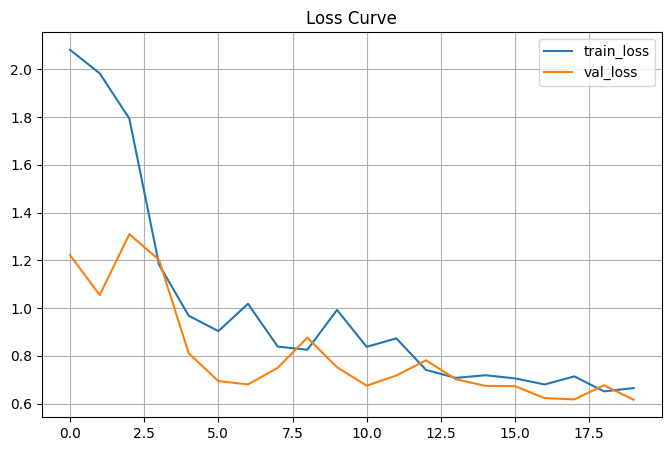

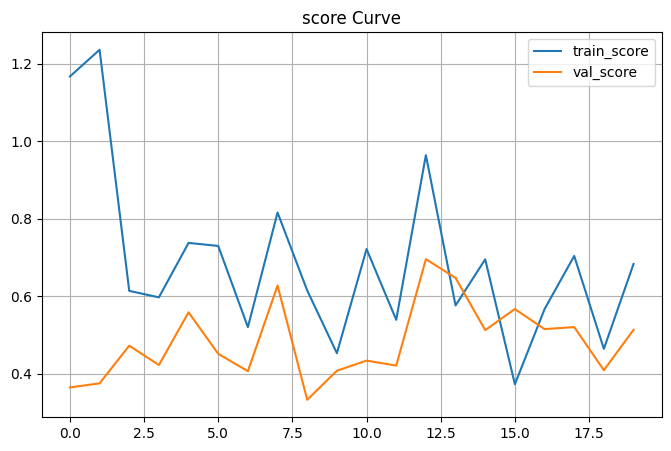

In [12]:
train_state_df = pd.DataFrame(train_state)
print(train_state_df)
plot_learning_curves(train_state_df[['train_loss', 'val_loss']], "Loss Curve")
plot_learning_curves(train_state_df[['train_score', 'val_score']], "score Curve")